# Parameter recovery and optimization of cell motility using the FitMultiCell pipeline

$\textit{Summary:}$

The FitMultiCell pipeline is applied to a cell motility model for the CPM with the goal of recovering the ground truth values of two parameters $\tau$ and $\phi$ and a comparison on the effects of time-coarsening is explored. Througout this notebook, time coarsening refers to the established time-gap to print the results in the Analysis cell of a Morpheus model. This was done for three values: 10, 50, 100. The results show that both parameters can be obtained with high accuracy for all three times, with better results for lower resolutions. 

The first part contains code used to translate the externally simulated data from Morpheus (a parameter sweep was used in order to iterate 100 times the simulation and work with better statistics) into a dictionary readable for pyABC. Then the FitMultiCell pipeline is applied for the specified times and the corresponding values from the externally simulated data. 

In [1]:
# Libraries:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import tidynamics      
from pyabc import SingleCoreSampler

ERROR:External:Install rpy2 to enable simple support for the R language.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-of-externally-simulated-data-from-Morpheus" data-toc-modified-id="Input-of-externally-simulated-data-from-Morpheus-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input of externally simulated data from Morpheus</a></span></li><li><span><a href="#My-model-with-time-coarsening-=-50" data-toc-modified-id="My-model-with-time-coarsening-=-50-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>My model with time coarsening = 50</a></span><ul class="toc-item"><li><span><a href="#Time-coarsening-=-10" data-toc-modified-id="Time-coarsening-=-10-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Time coarsening = 10</a></span></li><li><span><a href="#Time-coarsening-=-100" data-toc-modified-id="Time-coarsening-=-100-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Time coarsening = 100</a></span></li></ul></li><li><span><a href="#Comparison-of-time-resolution" data-toc-modified-id="Comparison-of-time-resolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison of time resolution</a></span></li><li><span><a href="#Outlook" data-toc-modified-id="Outlook-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Outlook</a></span></li></ul></div>

## Input of externally simulated data from Morpheus

One may desire to test a specific model/experimental data and an averaging process can minimize stochastic effects. This section shows how to transfer Morpheus simulated data to a dictionary that can be read by pyABC. 

In [5]:
# Making a sweep in Morpheus:

# Folder path with sweep generated by Morpheus:
path = '/Volumes/Sebi/FitMultiCell/Data_for_fitting/PRW_extended_with_LevyWalk_spontaneous_repolarization_sweep_24/'
def total_tracks(path, iterations, total_time, init_time):
    """
    Returns a ndarray with the total number of iterations/sweeps to average, 
    the time step between consecutive tracks and the initial time to 
    take the data (avoiding thermalization effects).
    """
    sweeps = os.listdir(path)
    sweeps.remove('sweep_header.csv')
    sweeps.remove('sweep_data.csv')
    #sweeps.remove('.DS_Store')# Sometimes needed if running in Mac
    sweeps.sort()
    data = np.zeros((iterations, total_time-init_time, 3))
    data_vel = np.zeros((iterations, total_time-init_time, 3))
    #count = 0
    for i in range(len(sweeps)):
        sweep_path = path + sweeps[i] + '/'
        cell_trajectory = pd.read_csv(sweep_path + 'logger.csv',
                                        sep='\t',header=(0))
        data[i,:,:] = np.array(cell_trajectory[['time', 'cell.center.x', 'cell.center.y']].iloc[init_time:])
        data_vel[i,:,:] = np.array(cell_trajectory[['velocity.x', 'velocity.y', 'velocity.abs']].iloc[init_time:])

    return data, data_vel

In [6]:
# This simulation was performed with 100 sweeps for 501 time points and took the data after time = 100
# Cells trajectories:
data_frame = total_tracks(path, 100, 501, 100)[0]
# Cells velocities:
data_vel = total_tracks(path, 100, 501, 100)[1]
# Avoiding 0 on velocity norm
norm = data_vel[:, :, 2]
norm[norm == 0] = 0.0001
data_vel[:, :, 2] = norm

This last part computes both the MSD and DAC functions from the simulated and averaged data and stores it in the same format as the "measured_data" dictionary used for the FitMultiCell pipeline.

In [7]:
def avg_MSD(df):
    time_points = len(df[0,:,0])
    MSD = np.zeros(time_points)

    for i in range(len(df[:])):
        p = tidynamics.msd(df[i,:])
        MSD += p
    return (MSD / len(df[:]))

def avg_DAC(df):
    time_points = len(df[0,:,0])
    DAC = np.zeros(time_points)

    for i in range(len(df[:])):
        t = tidynamics.acf(np.column_stack([df[i,:,0] / df[i, :, 2], df[i,:,1] / df[i, :, 2]]))
        DAC += t
    return (DAC / len(df[:]))

MSD_sim = avg_MSD(data_frame)
DAC_sim = avg_DAC(data_vel)


It is necessary to specify here the time resolution, shown below for time = 50. The data generated every 50 time steps is taken as the 'ground truth' and used to minimize the distance function with the simulated data.

In [8]:
 
MSD_coarse, DAC_coarse = [], []
for i in range(0, 450, 50):
    MSD_coarse.append(MSD_sim[i])
    DAC_coarse.append(DAC_sim[i])

measured_data = {'IdSumstat__time': np.array([i for i in np.arange(0,450,50)]),\
                 'IdSumstat__MSD': np.array(MSD_coarse),\
                 'IdSumstat__DAC': np.array(DAC_coarse)}

## My model with time coarsening = 50

In [9]:
file_ = "PRW_Thesis.xml"
par_map = {'tau': './Global/Constant[@symbol="tau"]',
           'phi': './Global/Constant[@symbol="phi"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

MorpheusModel {
	name      : PRW_Thesis.xml
}


In [10]:
true_pars = {'tau': 0.9, 'phi': 0.1}
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

# manually defined summary statistics

def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][2:],val1['IdSumstat__cell.center.y'][2:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][2:]/val1['IdSumstat__velocity.abs'][2:],val1['IdSumstat__velocity.y'][2:]/val1['IdSumstat__velocity.abs'][2:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [11]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#sampler=SingleCoreSampler()
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=65, start_time=2020-11-10 09:51:09.053022, end_time=None)>


In [12]:
abc.run(max_nr_populations = 7)# min_epsilon = 0.1, max_nr_populations = 4

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 530397.597190301
INFO:ABC:t: 0, eps: 530397.597190301.
INFO:ABC:Acceptance rate: 100 / 249 = 4.0161e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 530356.4932170254.
INFO:ABC:Acceptance rate: 100 / 389 = 2.5707e-01, ESS=9.0991e+01.
INFO:ABC:t: 2, eps: 530297.7939060463.
INFO:ABC:Acceptance rate: 100 / 495 = 2.0202e-01, ESS=9.1877e+01.
INFO:ABC:t: 3, eps: 529947.1308097194.
INFO:ABC:Acceptance rate: 100 / 544 = 1.8382e-01, ESS=9.7815e+01.
INFO:ABC:t: 4, eps: 527959.7999164856.
INFO:ABC:Acceptance rate: 100 / 277 = 3.6101e-01, ESS=9.2508e+01.
INFO:ABC:t: 5, eps: 525188.2814079485.
INFO:ABC:Acceptance rate: 100 / 406 = 2.4631e-01, ESS=8.2635e+01.
INFO:ABC:t: 6, eps: 520368.8064086334.
INFO:ABC:Acceptance rate: 100 / 539 = 1.8553e-01, ESS=8.1162e+01.
INFO:History:Done <ABCSMC(id=65, start_time=2020-11-10 09:51:09.053022, end_time=2020-11-10 10:06:44.974221)>


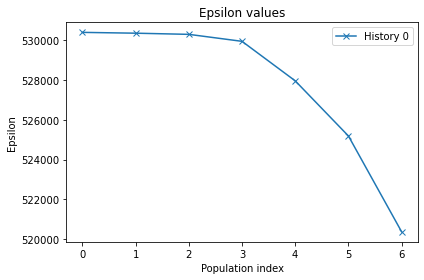

In [13]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

In [14]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=5,
        x="phi", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(true_pars["phi"], color="k", linestyle="dashed");
ax.legend();

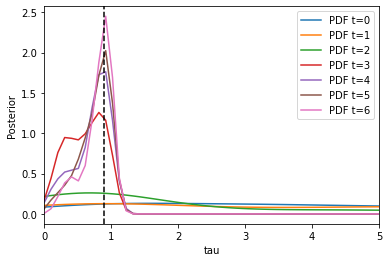

In [15]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=5,
        x="tau", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(true_pars["tau"], color="k", linestyle="dashed");
ax.legend();

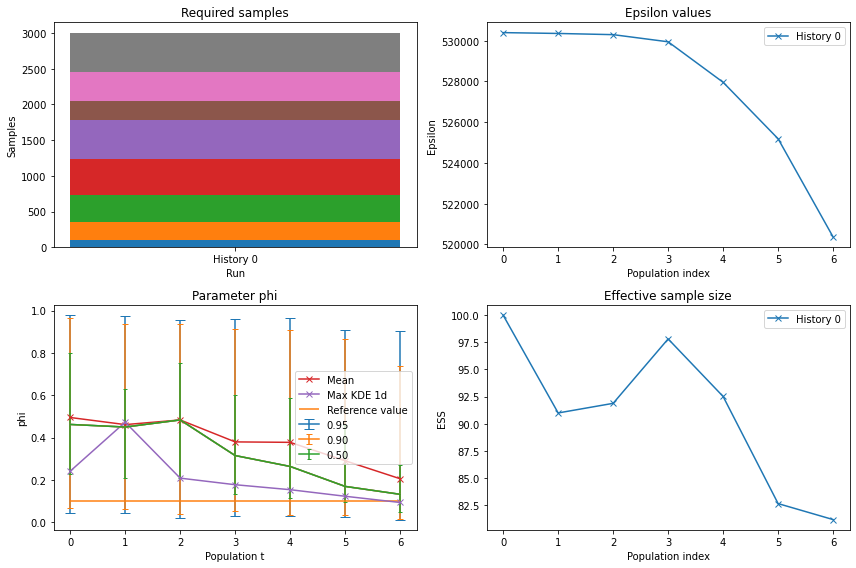

In [16]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
pyabc.visualization.plot_credible_intervals(
    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4, 5, 6],
    show_mean=True, show_kde_max_1d=True,
    refval={'phi': 0.1}, arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

### Time coarsening = 10

In [51]:
# Specify new file with time resolution = 10
file_ = "PRW_Thesis_10.xml"
par_map = {'tau': './Global/Constant[@symbol="tau"]',
           'phi': './Global/Constant[@symbol="phi"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

MorpheusModel {
	name      : PRW_Thesis_10.xml
}


In [52]:
# Redefine ground truth:
MSD_coarse, DAC_coarse = [], []
for i in range(0, 410, 10):
    MSD_coarse.append(MSD_sim[i])
    DAC_coarse.append(DAC_sim[i])

measured_data = {'IdSumstat__time': np.array([i for i in np.arange(0,410,10)]),\
                 'IdSumstat__MSD': np.array(MSD_coarse),\
                 'IdSumstat__DAC': np.array(DAC_coarse)}

In [53]:
# manually defined summary statistics:
def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][10:],val1['IdSumstat__cell.center.y'][10:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][10:]/val1['IdSumstat__velocity.abs'][10:],val1['IdSumstat__velocity.y'][10:]/val1['IdSumstat__velocity.abs'][10:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])
#distance = pyabc.PNormDistance(p=2)

In [54]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#sampler=SingleCoreSampler()
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=69, start_time=2020-11-10 12:02:40.124622, end_time=None)>


In [55]:
abc.run(max_nr_populations = 7)# min_epsilon = 0.1, max_nr_populations = 4

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 2304816.9831976793
INFO:ABC:t: 0, eps: 2304816.9831976793.
<ipython-input-53-17dcb3877081>:8: RuntimeWarning: invalid value encountered in true_divide
  d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][10:]/val1['IdSumstat__velocity.abs'][10:],val1['IdSumstat__velocity.y'][10:]/val1['IdSumstat__velocity.abs'][10:]]))\
INFO:ABC:Acceptance rate: 100 / 247 = 4.0486e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 2304593.8986163754.
INFO:ABC:Acceptance rate: 100 / 410 = 2.4390e-01, ESS=8.7767e+01.
INFO:ABC:t: 2, eps: 2304223.2018017094.
INFO:ABC:Acceptance rate: 100 / 524 = 1.9084e-01, ESS=8.8452e+01.
INFO:ABC:t: 3, eps: 2301071.9198659896.
INFO:ABC:Acceptance rate: 100 / 478 = 2.0921e-01, ESS=9.3994e+01.
INFO:ABC:t: 4, eps: 2290889.069650526.
INFO:ABC:Acceptance rate: 100 / 337 = 2.9674e-01, ESS=8.9513e+01.
INFO:ABC:t: 5, eps: 2275400.3061838015.
INFO:ABC:Acceptance rate: 100 / 408 = 2.4510e-01

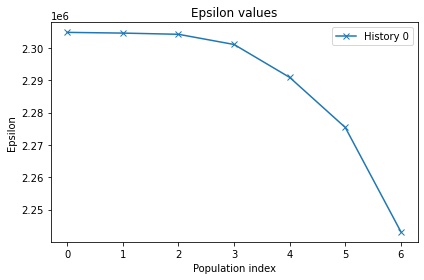

In [56]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

In [57]:
df10 = df
w10 = w

### Time coarsening = 100

In [38]:
# Specify new file with time resolution = 10
file_ = "PRW_Thesis_100.xml"
par_map = {'tau': './Global/Constant[@symbol="tau"]',
           'phi': './Global/Constant[@symbol="phi"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

In [39]:
# Redefine ground truth:
MSD_coarse, DAC_coarse = [], []
for i in range(0, 500, 100):
    MSD_coarse.append(MSD_sim[i])
    DAC_coarse.append(DAC_sim[i])

measured_data = {'IdSumstat__time': np.array([i for i in np.arange(0,500,100)]),\
                 'IdSumstat__MSD': np.array(MSD_coarse),\
                 'IdSumstat__DAC': np.array(DAC_coarse)}

In [40]:
def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][1:],val1['IdSumstat__cell.center.y'][1:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][1:]/val1['IdSumstat__velocity.abs'][1:],val1['IdSumstat__velocity.y'][1:]/val1['IdSumstat__velocity.abs'][1:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [41]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#sampler=SingleCoreSampler()
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=68, start_time=2020-11-10 10:58:14.732893, end_time=None)>


In [42]:
abc.run(max_nr_populations = 7)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 311674.3148495864
INFO:ABC:t: 0, eps: 311674.3148495864.
INFO:ABC:Acceptance rate: 100 / 170 = 5.8824e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 311647.84266494546.
INFO:ABC:Acceptance rate: 100 / 357 = 2.8011e-01, ESS=9.2480e+01.
INFO:ABC:t: 2, eps: 311615.1306392082.
INFO:ABC:Acceptance rate: 100 / 384 = 2.6042e-01, ESS=8.1273e+01.
INFO:ABC:t: 3, eps: 311320.5258789819.
INFO:ABC:Acceptance rate: 100 / 740 = 1.3514e-01, ESS=8.3550e+01.
INFO:ABC:t: 4, eps: 309571.2276812553.
INFO:ABC:Acceptance rate: 100 / 380 = 2.6316e-01, ESS=8.8771e+01.
INFO:ABC:t: 5, eps: 305505.4731962117.
INFO:ABC:Acceptance rate: 100 / 541 = 1.8484e-01, ESS=6.1093e+01.
INFO:ABC:t: 6, eps: 300911.8335317304.
INFO:ABC:Acceptance rate: 100 / 733 = 1.3643e-01, ESS=6.1099e+01.
INFO:History:Done <ABCSMC(id=68, start_time=2020-11-10 10:58:14.732893, end_time=2020-11-10 11:15:14.057043)>


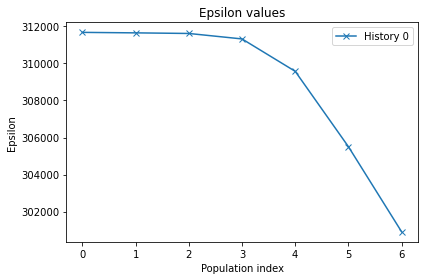

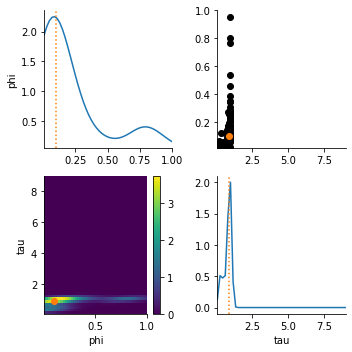

In [43]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

In [46]:
df100 = df
w100 = w

## Comparison of time resolution

The mean of the distributions calculated previously are compared in this section for the different times used to simulate the model: $t = 10, 50, 100$. 

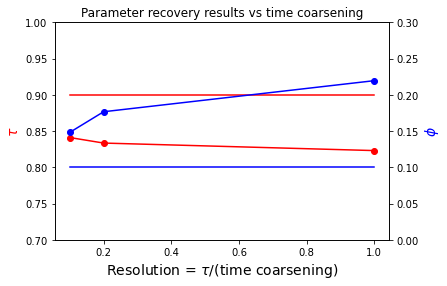

In [95]:
x_values = [0.1, 0.2, 1]
y1_values = [df100["tau"].mean(), df50["tau"].mean(), df10["tau"].mean()]
y2_values = [df100["phi"].mean(), df50["phi"].mean(), df10["phi"].mean()]


fig, ax = plt.subplots()
ax.plot(x_values, y1_values, color = "red", marker="o")
ax.plot([x_values[0], x_values[2]], [0.9, 0.9], color="red", label=r"$\tau$ reference value")
ax.set_xlabel(r"$\tau/$(time coarsening)", fontsize=14)
ax.set_ylabel(r"$\tau$", fontsize=14, color='red')
ax.set_ylim([0.7, 1])
ax2 = ax.twinx()
ax2.plot(x_values, y2_values, color="blue", marker="o")
ax2.plot([x_values[0], x_values[2]], [0.1, 0.1], color="blue", label=r"$\phi$ reference value")
ax2.set_ylabel(r"$\phi$", fontsize=14, color="blue")
ax2.set_ylim([0, 0.3])
ax.set_title("Parameter recovery results vs time coarsening")
plt.show()

The previous figure has the plot of mean $\tau$ (left-hand-side y-axis) and mean $\phi$ (right-hand-side y-axis) vs $\tau$/time coarsening. This means that if the SS are taken each 50 time steps and $\tau = 10$ then 0.1 would correspond to a low resolution. Interestingly, the most accurate results for the paameter recovery were obtained for the lowest time resolution and both parameters behave on opposite manner as the resolution increases ($\tau$ decreases while $\phi$ increases).

## Outlook

* Using $\beta(t)$ instead of $MSD$ for the summary statistics (might reduce epsilon). 
* Apply pipeline to Cell Polarity parameter recovery of Synchon.
* Start exploring experimental data and compare with model.